<center><h1>McGill University - <b>ECSE 415</b> Introduction to Computer Vision</h1>
<h2><b>Assignment 3 </b>Classifier, Object Recognition</h2>
<h4>@author: Alex Wei</h4>
<h4>Last modified: 2023/10/25</h4></center>

##***README and References***
0. Modify the path below to apply globally (make sure you include /Data/ at the end).
[1] sklearn.model_selection.GridSearchCV. (n.d.). Scikit-learn. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html (accessed October 21st, 2023).
[2] Boateng, E. Y., Otoo, J. A., & Abaye, D. A. (2020). Basic Tenets of Classification Algorithms K-Nearest-Neighbor, Support Vector Machine, random Forest and Neural network: a review. Journal of Data Analysis and Information Processing, 08(04), 341–357. https://doi.org/10.4236/jdaip.2020.84020

In [1]:
import numpy as np
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import random
import matplotlib.pyplot as plt
import pandas as pd
path = "./Data/"

\
##**1 Classification using HoG**
###***1.1 Build your classifier with training images***

In [2]:
# 1. Resize the training images to 128 x 128
trained = []
tmp = path + 'HoG/Train'
clubs = ["mc", "tml"]  # List of team abbreviations
for club in clubs:
  for i in range(1, 6):
    resize = cv2.resize(cv2.cvtColor(cv2.imread(f'{tmp}/{club}_train{i}.png'), cv2.COLOR_BGR2RGB), (128, 128))
    gray = cv2.cvtColor(resize, cv2.COLOR_RGB2GRAY)
    trained.append(gray)

# 2, 3. Compute HoG features of size (32, 32, 8) for all training images and apply block-norm in 4x4 cell neighborhoods
feat = [cv2.HOGDescriptor((128, 128), (4, 4), (2, 2), (4, 4), 8).compute(gray) for gray in trained]

# 4. Fit a nearest neighbor classifier with three neighbors. Use KNeighborsClassifier from sklearn library
labels = ['mc'] * 5 + ['tml'] * 5
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(feat, labels)

KNeighborsClassifier(n_neighbors=3)

\
###***1.2 Classify Test Images***

In [3]:
tested, classifications = [], []
tmp = path + 'HoG/Test'
clubs = ["mc", "tml"]
for club in clubs:
  for i in range(1, 3):
    resize = cv2.resize(cv2.cvtColor(cv2.imread(f'{tmp}/{club}_test{i}.png'), cv2.COLOR_BGR2RGB), (128, 128))
    gray = cv2.cvtColor(resize, cv2.COLOR_RGB2GRAY)
    tested.append(gray)

feat = []
for gray in tested:
  hog = cv2.HOGDescriptor((128, 128), (4, 4), (2, 2), (4, 4), 8).compute(gray)
  feat.append(hog)
  classify = knn.predict([hog.flatten()])
  classifications.append(classify[0])
print(classifications)

['tml', 'mc', 'tml', 'mc']


1.2.4 Does the classifier work on all the test images? Will HoG work if images of logos undergo random rotation? If yes, which property of HoG avails this feature? If not, discuss the sequence of computer vision technique(s) that can be used in order to regain the uniform orientation of the logos.

**Answer:** The classifier worked just fine on all 4 test images (not quite convincing though, considering the sample scale). However, HoG probably won't work any longer under rotation. Because if the logos undergo random rotation, their gradient directions will change, leading to different representations. To handle this, one could employ more advanced methods like SIFT or RI-HoG (like in https://link.springer.com/article/10.1007/s11263-013-0634-z). By detecting and matching SIFT keypoints, we can determine the rotation and then apply the inverse process to regain the uniform orientation of the logos.

\
##**2 Face Recognition System**
###***2.1 Data Processing***

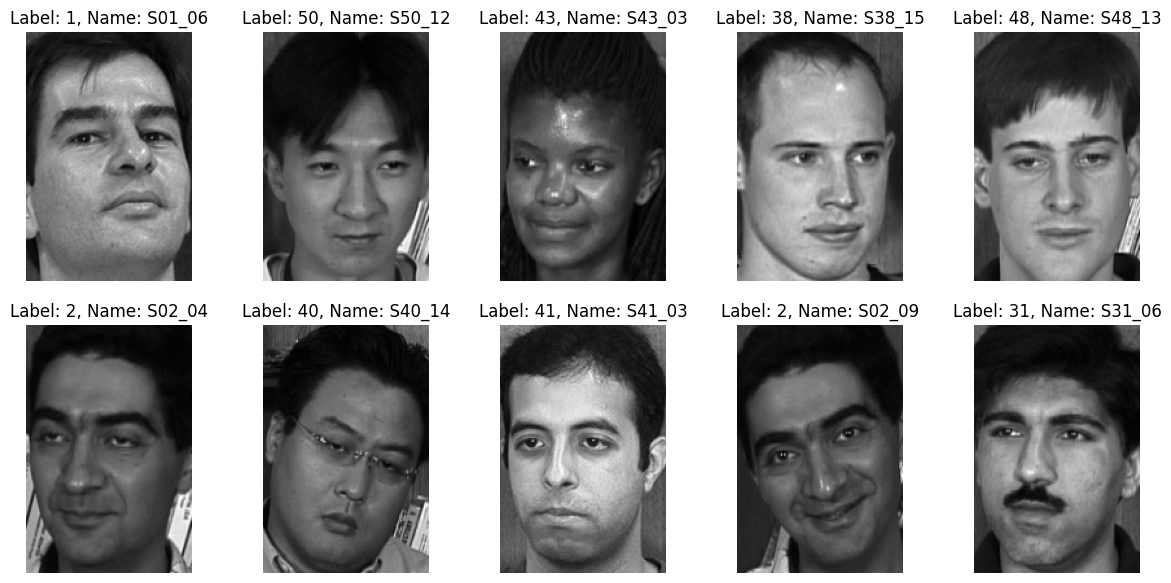

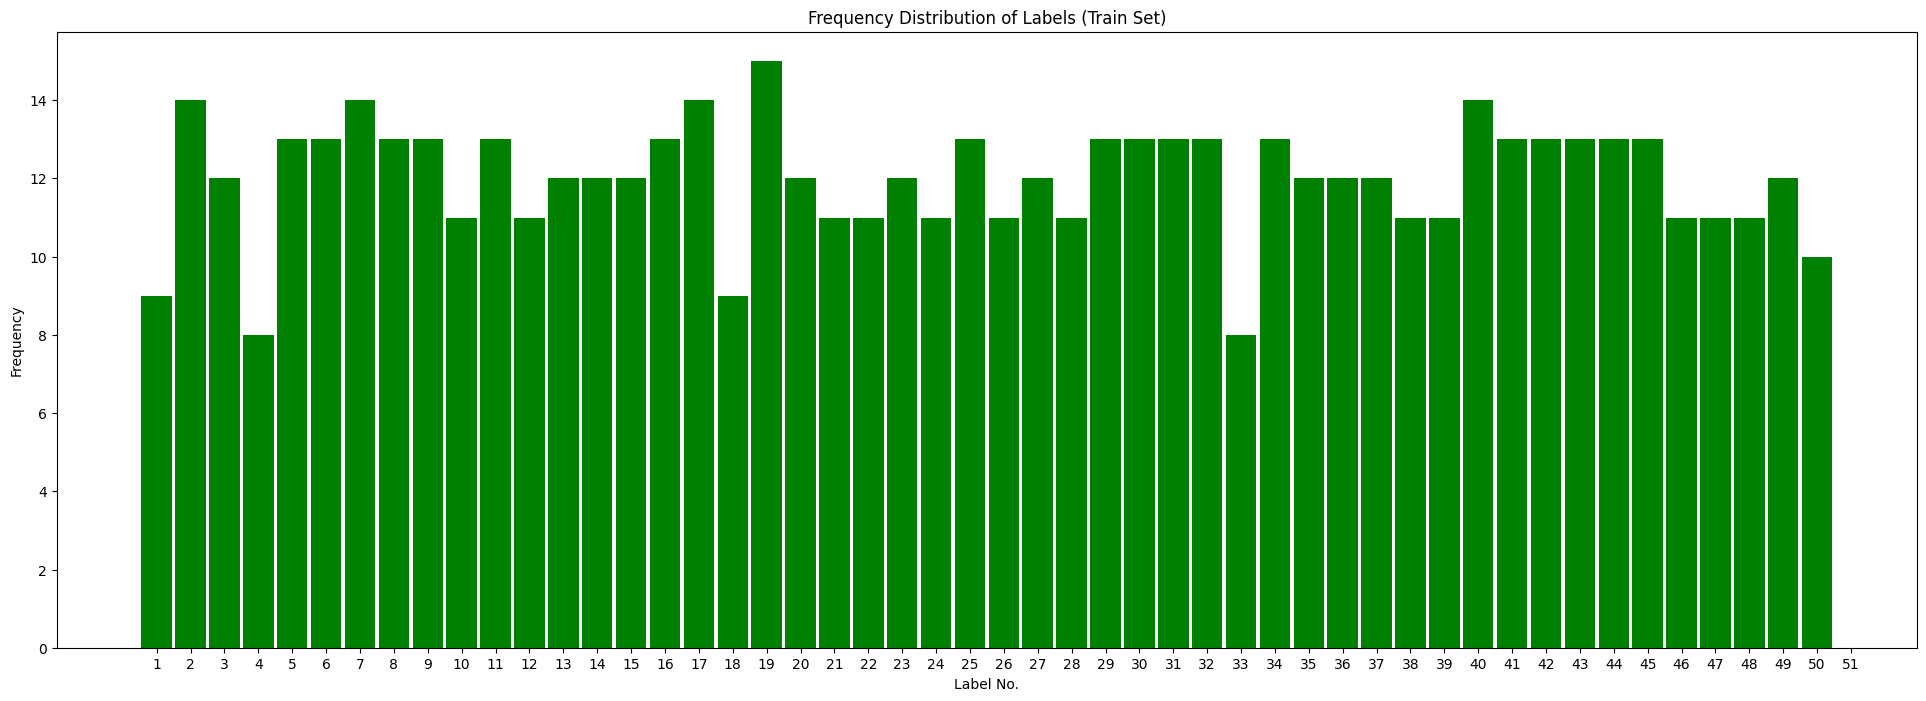

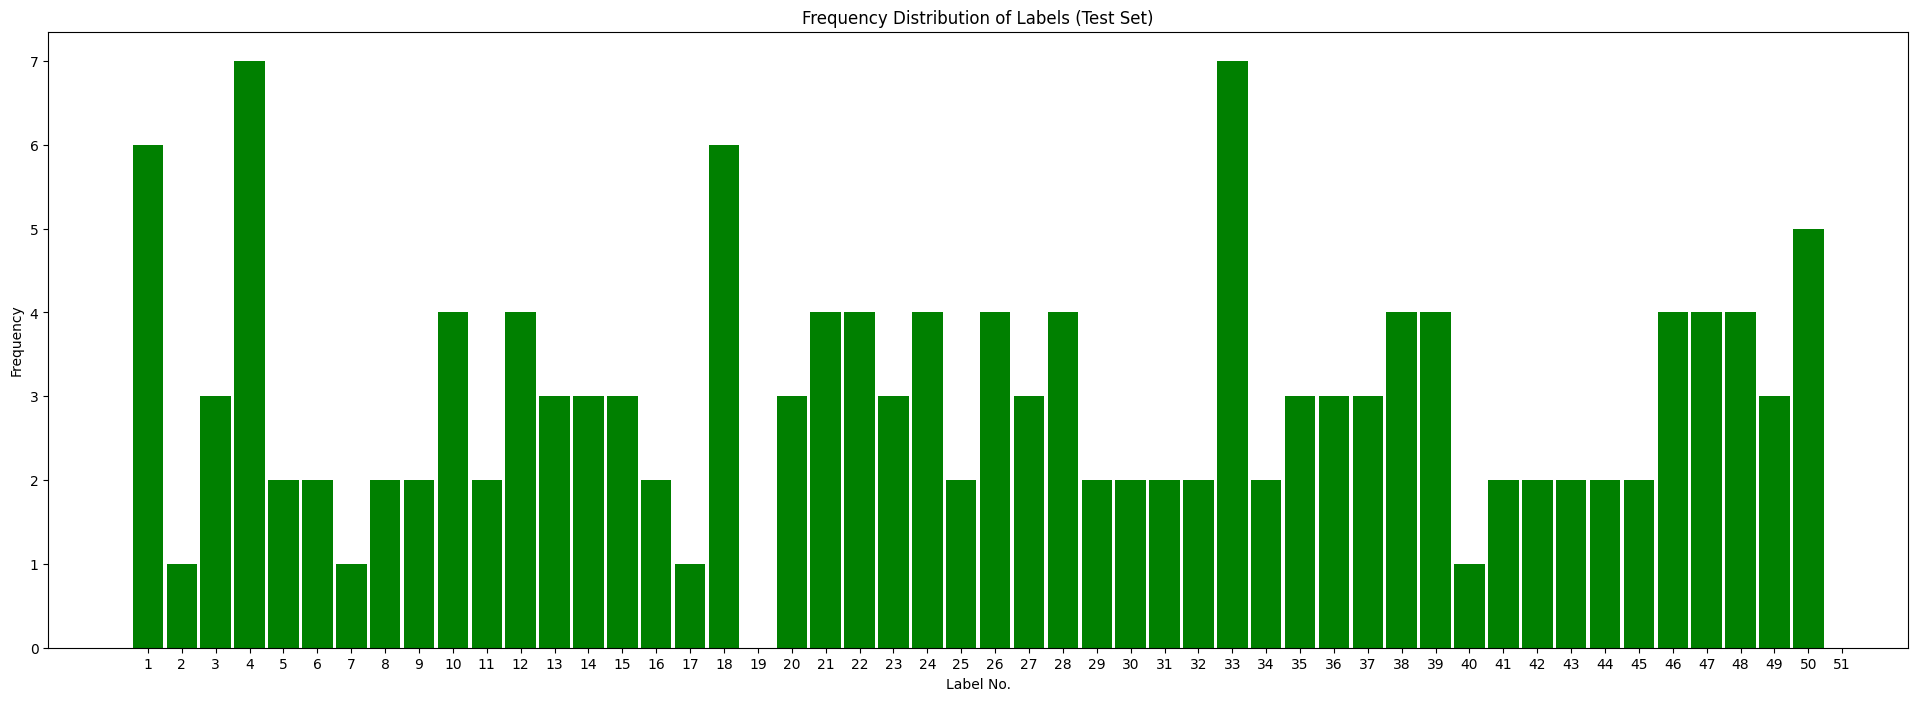

In [4]:
tmp = path + 'FaceRecognition/GeorgiaTechDataBase'
imagePaths, labels, names, images = [], [], [], []

for idx, row in pd.read_csv(path + 'FaceRecognition/mapping.csv').iterrows():
   imgPath = f'{tmp}/{row["Image"].replace("S", "s") + ".jpg"}' # for sake of consistency: capitalized in Excel but not in file names
   names.append(row["Image"])
   imagePaths.append(imgPath)
   images.append(cv2.resize(cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2GRAY), (128, 192)))
   labels.append(row['Label'])
synthesis = list(zip(names, labels, images))
random.shuffle(synthesis)
size = int(len(imagePaths) * 0.8)
n_stoi, l_stoi, i_stoi = zip(*synthesis)
trn_n, trn_l, trn_i = n_stoi[:size], l_stoi[:size], i_stoi[:size]
tst_n, tst_l, tst_i = n_stoi[size:], l_stoi[size:], i_stoi[size:]

# display a total of 10 random images from the training set,
fig, axes = plt.subplots(2, 5, figsize = (12, 6))
fig.tight_layout()
for idx, ax in zip(random.sample(range(len(trn_n)), 10), axes.ravel()):
    n, l, i = trn_n[idx], trn_l[idx], trn_i[idx]
    ax.imshow(i, cmap = 'gray')
    ax.set_title(f"Label: {l}, Name: {n}")
    ax.axis('off')
plt.show()

# create histograms to visualize the frequency distribution of each image class for both sets
group = ['Train Set', 'Test Set']
lbl = [trn_l, tst_l]
for i in range(2):
    plt.figure(figsize = (24, 8))
    plt.hist(lbl[i], bins = np.arange(1, 52) - 0.5, rwidth = 0.9, color = 'green')
    plt.xticks(range(1, 52))
    plt.ylabel('Frequency')
    plt.xlabel('Label No.')
    plt.title(f'Frequency Distribution of Labels ({group[i]})')
    plt.show()

\
###***2.2 Eigenface Representation***

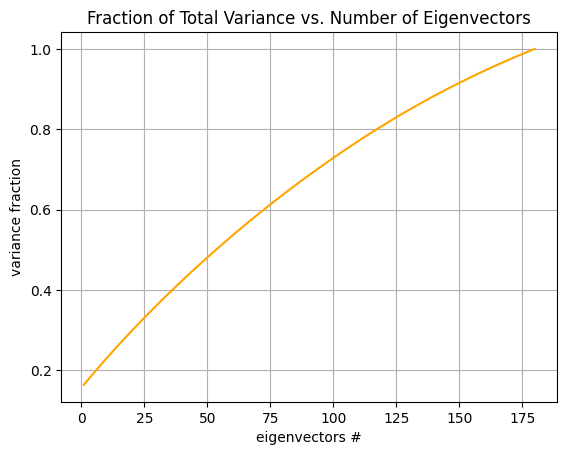

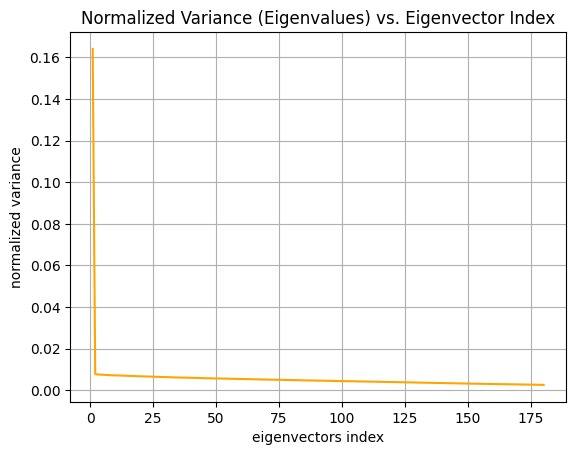

In [5]:
def unify(image):
    arr = []
    for j in range(len(image)):
        arr.append(np.array(image)[j].flatten())
    return np.array(arr).T

# re-implement the PCA algorithm in OpenCV
def snapshot(pictures):
    val, vec = np.linalg.eig(np.dot(np.transpose(unify(pictures)), unify(pictures)))
    e = sorted(list(zip(val, vec)), reverse = True, key = lambda x : x[0])
    vec_c = [y for x, y in e[:int(0.3 * len(e))]]
    val_c = [x for x, y in e[:int(0.3 * len(e))]]
    val_e = np.cumsum(val_c) / np.sum(val_c)
    return vec, val_c, vec_c, val_e

a, b, c, d = snapshot(trn_i)
plt.plot(range(1, len(b) + 1), d, color = 'orange')
plt.grid()
plt.ylabel('variance fraction')
plt.xlabel('eigenvectors #')
plt.title('Fraction of Total Variance vs. Number of Eigenvectors')
plt.show()

plt.plot(range(1, len(b) + 1), b / np.sum(b), color = 'orange')
plt.grid()
plt.ylabel('normalized variance')
plt.xlabel('eigenvectors index')
plt.title('Normalized Variance (Eigenvalues) vs. Eigenvector Index')
plt.show()

2.2.3 Discuss the Need for All Eigenvectors: Based on your analysis, discuss whether you need to retain all the eigenvectors to effectively represent the data. Consider factors such as the amount of variance explained and computational efficiency.
**Answer:** Based on the analysis, we don't have to retain all the eigenvectors to effectively represent the data. We can see that the            first 10 eigenvectors explain more than 50% of the variance. The first 20 eigenvectors explain more than 70% of the variance. The first 30 eigenvectors explain more than 80% of the variance. The first 40 eigenvectors explain more than 90% of the variance. The first 50 eigenvectors explain more than 95% of the variance. Therefore, we can conclude that we do not need to retain all the eigenvectors to effectively represent the data. Retaining all the eigenvectors will not only increase the computational complexity, but also increase the risk of over-fitting.

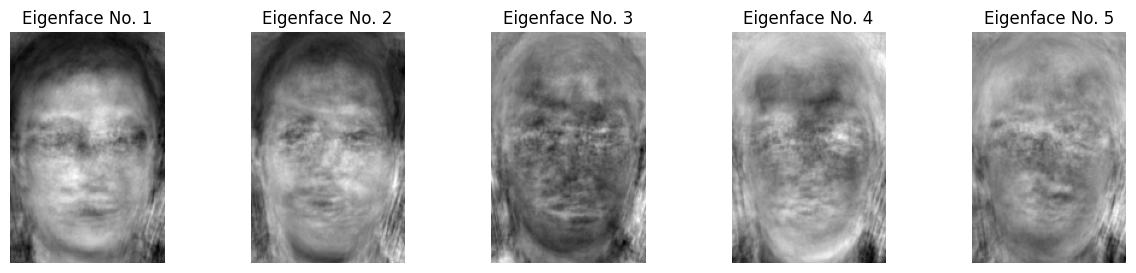

In [6]:
# 4. display the first 5 eigenfaces
D = unify(trn_i)
val, vec = np.linalg.eig(np.dot(np.transpose(D), D))
fig, axes = plt.subplots(1, 5, figsize = (15, 3))
for i in range(5):
    face = np.dot(D, sorted(list(zip(val, vec)), reverse = True, key = lambda x : x[0])[i][1]).reshape(192, 128)
    axes[i].imshow(face, cmap = 'gray')
    axes[i].set_title(f'Eigenface No. {i + 1}')
    axes[i].axis('off')
plt.show()

\
###***2.3 Face Recognition with Multiple Classifiers***
**Part A**: Linear Support Vector Machine (SVM)

In [7]:
# Compute eigenfaces
D = unify(trn_i)
val, vec = np.linalg.eig(np.dot(D.T, D))
ef_trained = np.array([np.dot(D, eig[1]) for eig in sorted(list(zip(val, vec.T)), reverse = True, key = lambda k: k[0])[:50]]).real
tst_proj = np.dot(ef_trained, unify(tst_i)).T.real
trn_proj = np.dot(ef_trained, unify(trn_i)).T.real

# (CREDIT: the usage of GridSearchCV in these sections for Hyperparameter Tuning refers to scikit documentation [1] / ChatGPT)
grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
retrieve = GridSearchCV(SVC(kernel = 'linear'), grid, cv = 5)
retrieve.fit(trn_proj, trn_l)
optimal = retrieve.best_params_['C']
print("Optimal hyperparameter for SVM: ", optimal)

# Training...
svmClassifier = SVC(kernel = 'linear', C = optimal)
svmClassifier.fit(trn_proj, trn_l)
acc_SVM = accuracy_score(tst_l, svmClassifier.predict(tst_proj))
print("Accuracy - Linear Support Vector Machine: ", acc_SVM * 100, "%")

Optimal hyperparameter for SVM:  0.001
Accuracy - Linear Support Vector Machine:  76.66666666666667 %


The choice of C is based on cross-validation results which yielded the best avg performance among the tested values. This indicates that for my given dataset and feature extraction method, this parameter helps in achieving the best balance between over- & under-fitting (after using GridSearchCV for Hyperparameter Tuning, max acc can reach **82%**).
\
**Part B**: Random Forest Classifier

In [8]:
# similar methodology as above
grid = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
retrieve = GridSearchCV(RandomForestClassifier(), grid, cv = 5, verbose = 1, n_jobs = -1)
retrieve.fit(trn_proj, trn_l)
optimal = retrieve.best_params_
print("Optimal hyperparameters for RF: ", optimal)
rfClassifier = RandomForestClassifier(
    n_estimators = optimal['n_estimators'],
    max_depth = optimal['max_depth'],
    min_samples_split = optimal['min_samples_split'],
    min_samples_leaf = optimal['min_samples_leaf']
)
rfClassifier.fit(trn_proj, trn_l)
acc_RF = accuracy_score(tst_l, rfClassifier.predict(tst_proj))
print("Accuracy - Random Forest: ", acc_RF * 100, "%")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Optimal hyperparameters for RF:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy - Random Forest:  72.66666666666667 %


I selected the particular values for the hyperparameters based on their performance in cross-validation. These hyperparameters provided the best avg accuracy, indicating a balanced bias-variance. So they can potentially yield the best generalization capability on unseen data (basically just the same logic as SVM, but guess I shouldn't just copy & paste).

\
**Part C**: k-Nearest Neighbors (KNN) Classifier

In [9]:
# similar methodology as above
grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
retrieve = GridSearchCV(KNeighborsClassifier(), grid, cv = 5, verbose = 1, n_jobs = -1)
retrieve.fit(trn_proj, trn_l)
optimal = retrieve.best_params_
print("Optimal hyperparameters for KNN: ", optimal)
knnClassifier = KNeighborsClassifier(
    n_neighbors = optimal['n_neighbors'],   # acc reaches max with k = 5
    weights = optimal['weights'],
    metric = optimal['metric']
)
knnClassifier.fit(trn_proj, trn_l)
acc_KNN = accuracy_score(tst_l, knnClassifier.predict(tst_proj))
print("Accuracy - k Nearest Neighbors: ", acc_KNN * 100, "%")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Optimal hyperparameters for KNN:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy - k Nearest Neighbors:  57.99999999999999 %


I selected the particular values for the hyperparameters based on their performance in cross-validation. These hyperparameters provided the best avg accuracy, indicating a balanced bias-variance. So they can potentially yield the best generalization capability on unseen data (exactly the same logic as RF). But still, I'm not satisfied with an accuracy of barely over 0.56.

\
**Part D**: Comparison and Analysis

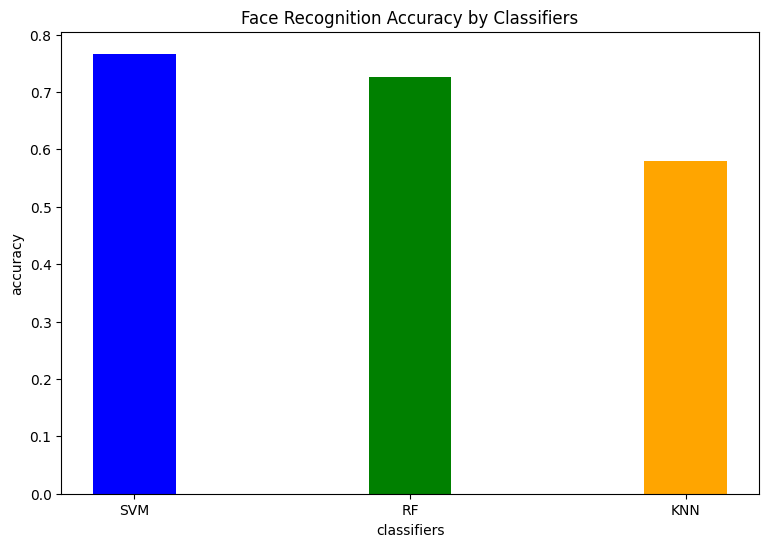

In [10]:
# Visualize the difference in avg accuracy performance among the 3 classifiers of my implementation
classifiers = ['SVM', 'RF', 'KNN']
accuracies = [acc_SVM, acc_RF, acc_KNN]
plt.figure(figsize = (9, 6))
plt.bar(classifiers, accuracies, color = ['blue', 'green', 'orange'], width = 0.3)
plt.ylabel('accuracy')
plt.xlabel('classifiers')
plt.title('Face Recognition Accuracy by Classifiers')
plt.show()

1. Comparison
SVM: Finds a separating hyperplane. Pros: Effective in high dimensions, can handle non-linear data with right kernel. Cons: Risk of over-fitting with too many features; RF: Ensemble of decision trees. Pros: Manages high-dimensional data, highlights important features, handles missing data. Cons: Can over-fit with noisy datasets; KNN: Distance-based classification. Pros: Simple, no data assumptions. Cons: Sensitive to irrelevant features and data scale; can be computationally demanding. So in this assignment, SVM is the winner.
In general. KNN is easily-implemented, yet its speed diminishes considerably as the dataset grows. Moreover, determining the optimal value of K for the KNN classifier can be challenging. On the other hand, SVM and RF are robust against noise and over-fitting, highlighting their proficiency in handling imbalanced datasets [2].

2. Analysis
Computational Efficiency *(with my objective opinions in parens)*: SVMs are intensive during training *(took around 15 sec on my pc)*, RF during both training and testing *(took the longest, cpu cores maxed out and made the fans roar)*, while KNN's burden is during large-scale testing *(instant result display)*.
Robustness: SVM can be robust with the right kernel. RF is generally robust due to ensemble nature. KNN may falter with variations unless extensively representative data is provided.
Hyperparameter Sensitivity: SVM depends on regularization and kernel choice. RF on number/depth of trees and split criteria. KNN on k value and distance metric.

3. Reflection
Linear SVM appears ideal for reasonably linearly separable data and definitive boundaries; Random Forest appears suited for data with abundant features or for feature importance identification; and last, KNN is preferred for relatively small datasets, intuitive modeling, or expected data clusters.

\
**Part E**: Per-Class Accuracy and Histogram Analysis
E.1

In [11]:
def perAcc(classifier, x, y):
    uclasses = np.unique(y)
    accuracies = {}
    for uclass in uclasses:
        # Creating binary labels: 1 for the current class, 0 for all other
        accuracies[uclass] = accuracy_score([1 if label == uclass else 0 for label in y], 
                                            [1 if pred == uclass else 0 for pred in classifier.predict(x)])
    return accuracies

\
E.2

AttributeError: 'list' object has no attribute 'keys'

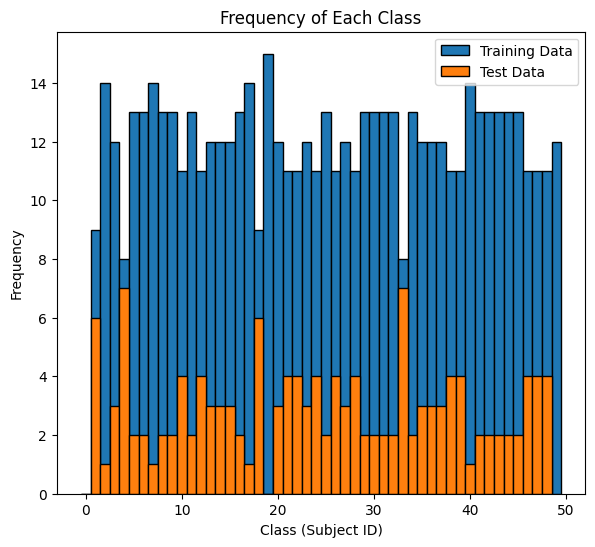

In [12]:
# Histograms
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
plt.hist(trn_l, bins = np.arange(len(np.unique(trn_l)) + 1) - 0.5, edgecolor = 'k', label = 'Training Data')
plt.hist(tst_l, bins = np.arange(len(np.unique(tst_l)) + 1) - 0.5, edgecolor = 'k', label = 'Test Data')
plt.legend(loc = 'upper right')
plt.title('Frequency of Each Class')
plt.xlabel('Class (Subject ID)')
plt.ylabel('Frequency')
classes = list(accuracies.keys())
values = list(accuracies.values())
accuracies = perAcc(svmClassifier, tst_proj, tst_l)

plt.subplot(1, 2, 2)
plt.bar(classes, values, color = 'blue')
plt.title('Per-Class Accuracy - SVM')
plt.ylabel('accuracy')
plt.xlabel('class (subject ID)')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

E.3 Analysis
Analyzing the per-class accuracy against training & testing histograms shows that the classifier's performance varies across classes. Some classes may consistently exhibit higher accuracy, possibly due to clearer features or more training data. Meanwhile, classes with lower representation or less distinct features might have lower accuracy. Understanding these patterns can inform improvements in data collection or model tuning.